In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pImpactR as impact
from copy import deepcopy as copy
from scipy.signal import hilbert

In [2]:
EmitStr = ['7','14','28']
tunex = 0.8538658
maxTurn = 5
_x = 2
_xSTR = 'Y'
n_particles = 32000

In [3]:
Me = impact.util.Me
ke = 100*1.0e6
energy = ke+Me
freq = 30*1.0e6
offset = 0.001

g = energy/Me
bg = np.sqrt(g**2-1.0)

Emit  = [float(emit)*1.0e-9 for emit in EmitStr]
EmitN = [float(emit)*bg*1.0e-9 for emit in EmitStr]

In [4]:
NL_t = 0.4
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3
alfx = np.tan(np.pi*NL_mu)
betx = NL_L/np.sin(2.0*np.pi*NL_mu)

In [5]:
X=[]
nMax=[]
i=0
for i in range(len(EmitStr)):
    nMax.append(int(maxTurn/np.sqrt(EmitN[i])))
    X.append(np.real(np.load(_xSTR+'.mid.emit'+EmitStr[i]+'nm.npy'))[:nMax[i]])
    i=i+1

# Find maxoffset position

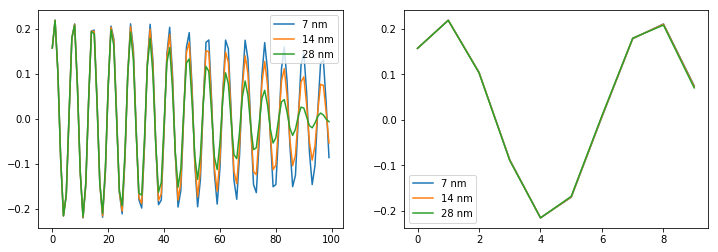

In [6]:
legend = [emit + ' nm' for emit in EmitStr]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for i in range(len(Emit)):
    plt.plot(X[i][:100])
plt.legend(legend)
plt.subplot(1,2,2)
for i in range(len(Emit)):
    plt.plot(X[i][:10])
plt.legend(legend)

In [7]:
N=[]
for i in range(len(Emit)):
    X[i] = X[i][1:]
    X[i] = X[i]/X[i][0]
    N.append(np.arange(len(X[i]))*np.sqrt(EmitN[i]))

In [8]:
fftX = []
Tune = []
for i in range(len(EmitStr)):
    fftX.append(np.fft.fft(X[i]))
    Tune.append(np.linspace(0,1-1.0/len(X[i]),len(X[i])))

1.0003795339679198
1.0015087324994503


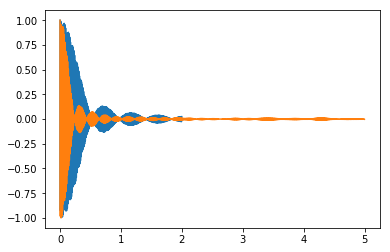

In [9]:
def KVdist(x):
    r = 2.0
    norm = 1.0/(4*np.pi)
    if x**2<=r**2:
        y = np.sqrt(r**2-x**2)
    else:
        y = 0
    return 2*y*norm
KVdist = np.vectorize(KVdist)
Q = np.linspace(-20.0,20.0,1000)
histData = KVdist(Q)
dq = Q[1]-Q[0]
# check
print(np.sum(histData*dq))
print(np.sum(Q*Q*histData*dq))


def DFT(x,k):
    T = np.arange(len(x))
    return np.sum(x*np.exp(-1j*k*T))

emit0 = 14.0e-9/(NL_c**2)
T = int(2.0/(np.sqrt(emit0*NL_c**2*bg)))
centData = np.zeros(T,dtype=np.complex)
dw_dI = -2*np.pi*0.65346402
xN = offset/betx**0.5/NL_c
pN = alfx*offset/betx**0.5/NL_c
offsetN = (xN**2+pN**2)**0.5
for t in range(T):
    centData[t] = np.sum(histData*np.exp(-1j*t*emit0**0.5*Q*offsetN*dw_dI)*dq)*np.exp(-2j*np.pi*t*tunex)
centData = np.real(centData)

T = np.arange(len(centData))*np.sqrt(emit0*NL_c**2*bg)
plt.plot(T,centData)
plt.plot(N[1],X[1])

# Raw Data

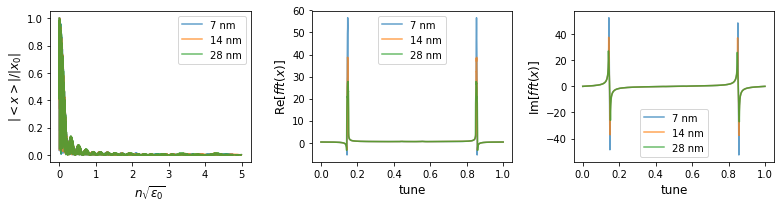

In [10]:
plt.figure(figsize=(11,3))
plt.subplot(1,3,1)
for i in range(len(Emit)):
    plt.plot(N[i],np.abs(X[i])/np.abs(X[i][0]),alpha=0.7)
plt.xlabel(r'$n\sqrt{\epsilon_0}$',fontsize=12);
plt.ylabel(r'$|< x >| / |x_0|$',fontsize=12);
plt.legend(legend)

plt.subplot(1,3,2)
for i in range(len(EmitStr)):
    plt.plot(Tune[i],np.real(fftX[i]),alpha=0.7)
plt.xlabel('tune',fontsize=12);
plt.ylabel(r'Re$\left[fft\left( x \right)\right]$',fontsize=12);
plt.legend(legend)

plt.subplot(1,3,3)
for i in range(len(EmitStr)):
    plt.plot(Tune[i],np.imag(fftX[i]),alpha=0.7)
plt.xlabel('tune',fontsize=12);
plt.ylabel(r'Im$\left[fft\left( x \right)\right]$',fontsize=12);
plt.legend(legend)

plt.tight_layout()
plt.savefig('Centroid.fft.mid.png',dpi=180,bbox_inches = "tight")

# dft zoom

In [11]:
nSample = 1024
Tune= []
Amp = []
for i in range(len(Emit)):
    Tune.append(tunex + np.linspace(-100.0,100.0,nSample)*np.sqrt(float(Emit[i])))
    Amp.append(np.zeros(nSample,dtype=np.complex128))
    n=len(X[i])
    for k in range(nSample):
        Amp[i][k] = np.sum(X[i]*np.exp(-1j*2.0*np.pi*Tune[i][k]*np.arange(0,n)+1j*0.15))
    Amp[i] = Amp[i]*np.sqrt(float(Emit[i]))*n_particles

pData = impact.readParticleData(-111114,ke,Me,freq)
# pDataInit[:,_x+1] = pDataInit[:,_x]*alfx/np.sqrt(betx)/NL_c + pDataInit[:,_x+1]*np.sqrt(betx)/NL_c
# pDataInit[:,_x  ] = pDataInit[:,_x]/np.sqrt(betx)/NL_c

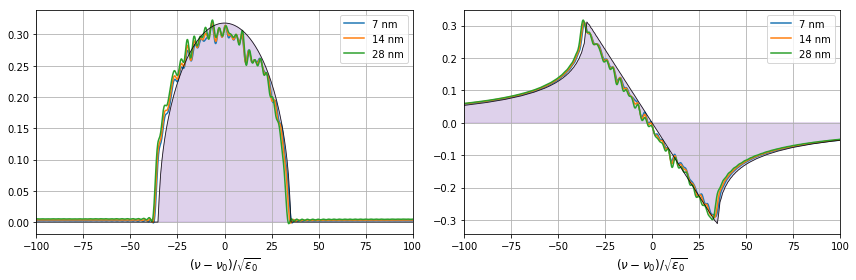

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(len(Emit)):
    plt.plot(np.linspace(-100.0,100.0,nSample),np.real(Amp[i])*0.0021)
plt.plot(Q*2**0.5*(2*np.pi)/(dw_dI*offsetN),histData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q*2**0.5*(2*np.pi)/(dw_dI*offsetN), 0, histData,color='C4',alpha=0.3)
plt.xlim(-100,100)
plt.xlabel(r'$(\nu-\nu_0)/\sqrt{\epsilon_0}$',fontsize=12);
plt.legend(legend)
plt.grid()

hilbertData = np.imag(hilbert(histData))
plt.subplot(1,2,2)
for i in range(len(Emit)):
    plt.plot(np.linspace(-100.0,100.0,nSample),np.imag(Amp[i])*0.0021)
plt.plot(Q*2**0.5*(2*np.pi)/(dw_dI*offsetN),hilbertData,color='k',alpha=0.9,linewidth=0.8)
plt.fill_between(Q*2**0.5*(2*np.pi)/(dw_dI*offsetN), 0, hilbertData,color='C4',alpha=0.3)
plt.xlabel(r'$(\nu-\nu_0)/\sqrt{\epsilon_0}$',fontsize=12);
plt.xlim(-100,100)
plt.legend(legend)
plt.grid()
plt.tight_layout()
plt.savefig('dft.mid.v0.png',dpi=180,bbox_inches = "tight")

In [13]:
from scipy import stats
def poincare(X,Y, samplePeriod=1, xlim=None, ylim=None, xlabel=None, ylabel=None, mksize=10):
    X=X[0::samplePeriod];Y=Y[0::samplePeriod]
    kernel = stats.gaussian_kde([X,Y])
    cData = kernel.evaluate([X,Y])
    plt.scatter(X,Y, c=cData, s=mksize, lw = 0)
    if xlim==None:
        xlim = [min(X),max(X)]
    plt.xlim(xlim[0],xlim[1])
    if ylim==None:   
        ylim = [min(Y),max(Y)]
    plt.ylim(ylim[0],ylim[1])
    if xlabel!=None:
        plt.xlabel(xlabel)
    if ylabel!=None:
        plt.ylabel(ylabel)

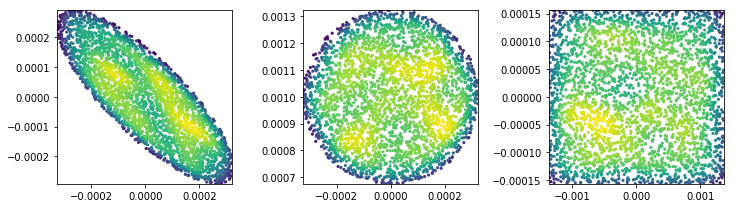

In [14]:
vec = bg/g*impact.data.clight
plt.figure(figsize=[10.3,3])
plt.subplot(1,3,1)
poincare(pData[:,0],pData[:,1],samplePeriod=10)
plt.subplot(1,3,2)
poincare(pData[:,0],pData[:,2],samplePeriod=10)
plt.subplot(1,3,3)
poincare(pData[:,4]/freq*vec/360,pData[:,5]/ke,samplePeriod=10)
plt.tight_layout()